In [1]:
#%%time
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt.74 : Band Aid n02786058
3.33 : spatula n04270147
3.13 : panpipe, pandean pipe, syrinx n03884397
2.62 : swimming trunks, bathing trunks n04371430
1.90 : knee pad n03623198
1.90 : Windsor tie n04591157
1.67 : conch n01943899
1.60 : paintbrush n03876231
1.43 : ballpoint, ballpoint pen, ballpen, Biro n02783161
1.22 : matchstick n03729826
%matplotlib inline

import pandas as pd

from scipy.io import loadmat
from scipy import stats
#from scipy.interpolate import spline
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import percentileofscore

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.cluster import KMeans

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input, ZeroPadding2D,merge,Lambda
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.optimizers import SGD
from keras import backend as K
from keras.engine import Layer
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from keras.layers.core import  Lambda
from keras.regularizers import l2
import cv2
#}

Using Theano backend.


In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
def preprocess_image(image_paths, image_height=224, image_width=224,color_mode='rgb'):
    """resize images to the appropriate dimensions
    :param image_width:
    :param image_height:
    :param image: image
    :return: image
    """
    img_list = []
    
    for im_path in image_paths:
        image = cv2.imread(im_path)
        image = cv2.resize(image, (image_height, image_width))
        
        image = image.astype('float32')
        image[:, :, 0] -= 123.68
        image[:, :, 1] -= 116.779
        image[:, :, 2] -= 103.939
        if color_mode == 'bgr':
            image = image.transpose((2, 0, 1))
        
        img_list.append(image)
        
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')
    return img_batch

In [4]:
#Helper function to normalization across channels
K.set_image_dim_ordering('th')
def crosschannelnormalization(.74 : Band Aid n02786058
3.33 : spatula n04270147
3.13 : panpipe, pandean pipe, syrinx n03884397
2.62 : swimming trunks, bathing trunks n04371430
1.90 : knee pad n03623198
1.90 : Windsor tie n04591157
1.67 : conch n01943899
1.60 : paintbrush n03876231
1.43 : ballpoint, ballpoint pen, ballpen, Biro n02783161
1.22 : matchstick n03729826alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        if K.image_dim_ordering()=='tf':
            b, r, c, ch = X.get_shape()
        else:
            b, ch, r, c = X.shape

        half = n // 2
        square = K.square(X)
        scale = k
        if K.image_dim_ordering() == 'th':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0,0),(half,half)))
            extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
            for i in range(n):
                scale += alpha * extra_channels[:, i:i+ch, :, :]
        if K.image_dim_ordering() == 'tf':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 3, 1, 2)), (half, 0))
            extra_channels = K.permute_dimensions(extra_channels, (0, 2, 3, 1))
            for i in range(n):
                scale += alpha * extra_channels[:, :, :, i:i+int(ch)]
        scale = scale ** beta
        return X / scale


    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [5]:
#Helper Function to split tensor
def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        div = K.shape(X)[axis] // ratio_split

        if axis == 0:
            output = X[id_split*div:(id_split+1)*div, :, :, :]
        elif axis == 1:
            output = X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:, :, id_split*div:(id_split+1)*div, :]
        elif axis == 3:
            output = X[:, :, :, id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")
        return output

    def g(input_shape):
        output_shape = list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)


    return Lambda(f, output_shape=lambda input_shape: g(input_shape), **kwargs)

In [6]:
#Alexnet layer architecture class
def AlexNet(img_shape=(3, 227, 227), n_classes=1000, l2_reg=0.,weights_path=None, lambda_mask=None):

    dim_ordering = K.image_dim_ordering()
    print(dim_ordering)
    if dim_ordering == 'th':
        batch_index = 0
        channel_index = 1
        row_index = 2
        col_index = 3
    if dim_ordering == 'tf':
        batch_index = 0
        channel_index = 3
        row_index = 1
        col_index = 2
        
    
    inputs = Input(img_shape)
.74 : Band Aid n02786058
3.33 : spatula n04270147
3.13 : panpipe, pandean pipe, syrinx n03884397
2.62 : swimming trunks, bathing trunks n04371430
1.90 : knee pad n03623198
1.90 : Windsor tie n04591157
1.67 : conch n01943899
1.60 : paintbrush n03876231
1.43 : ballpoint, ballpoint pen, ballpen, Biro n02783161
1.22 : matchstick n03729826
    conv_1 = Convolution2D(96, 11, 11, subsample=(4, 4), activation='relu',
                           name='conv_1', W_regularizer=l2(l2_reg))(inputs)

    if lambda_mask is not None:
        conv_1_mask  = np.reshape(lambda_mask[0:290400], (96,55,55))
    else:.74 : Band Aid n02786058
3.33 : spatula n04270147
3.13 : panpipe, pandean pipe, syrinx n03884397
2.62 : swimming trunks, bathing trunks n04371430
1.90 : knee pad n03623198
1.90 : Windsor tie n04591157
1.67 : conch n01943899
1.60 : paintbrush n03876231
1.43 : ballpoint, ballpoint pen, ballpen, Biro n02783161
1.22 : matchstick n03729826
        conv_1_mask = np.ones(shape=((96, 55, 55)))
    
    conv_1_mask  = K.variable(conv_1_mask)
    conv_1_lambda = Lambda(lambda x: x * conv_1_mask)(conv_1)

    conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1_lambda)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2, 2))(conv_2)
    conv_2 = merge([
        Convolution2D(128, 5, 5, activation="relu", name='conv_2_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_2)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_2")

    if lambda_mask is not None:
        conv_2_mask  = np.reshape(lambda_mask[290400:477024],(256, 27, 27) )
    else:
        conv_2_mask = np.ones(shape=((256, 27, 27)))
        
    conv_2_mask = K.variable(conv_2_mask)
    conv_2_lambda = Lambda(lambda x: x * conv_2_mask)(conv_2)

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2_lambda)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Convolution2D(384, 3, 3, activation='relu', name='conv_3',
                           W_regularizer=l2(l2_reg))(conv_3)

    if lambda_mask is not None:
        conv_3_mask  = np.reshape(lambda_mask[477024:541920],(384, 13, 13))
    else:
        conv_3_mask = np.ones(shape=((384, 13, 13)))
    
    conv_3_mask = K.variable(conv_3_mask)
    conv_3_lambda = Lambda(lambda x: x * conv_3_mask)(conv_3)

    conv_4 = ZeroPadding2D((1, 1))(conv_3_lambda)
    conv_4 = merge([
        Convolution2D(192, 3, 3, activation="relu", name='conv_4_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_4)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_4")

    if lambda_mask is not None:
        conv_4_mask  = np.reshape(lambda_mask[541920:606816],(384, 13, 13))
    else:
        conv_4_mask = np.ones(shape=((384, 13, 13)))
        
    conv_4_mask = K.variable(conv_4_mask)
    conv_4_lambda = Lambda(lambda x: x * conv_4_mask)(conv_4)

    conv_5 = ZeroPadding2D((1, 1))(conv_4_lambda)
    conv_5 = merge([
        Convolution2D(128, 3, 3, activation="relu", name='conv_5_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_5)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_5")

    if lambda_mask is not None:
        conv_5_mask  = np.reshape(lambda_mask[606816:650080],(256, 13, 13))
    else:
        conv_5_mask = np.ones(shape=((256, 13, 13)))
    
    conv_5_mask = K.variable(conv_5_mask)
    conv_5_lambda = Lambda(lambda x: x * conv_5_mask)(conv_5)

    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name="convpool_5")(conv_5_lambda)

    dense_1 = Flatten(name="flatten")(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1',
                    W_regularizer=l2(l2_reg))(dense_1)

    if lambda_mask is not None:
        dense_1_mask  = np.reshape(lambda_mask[650080:654176],(4096,))
    else:
        dense_1_mask = np.ones(shape=((4096,)))
    
    
    dense_1_mask = K.variable(dense_1_mask)
    dense_1_lambda = Lambda(lambda x: x * dense_1_mask)(dense_1)

    dense_2 = Dropout(0.5)(dense_1_lambda)
    dense_2 = Dense(4096, activation='relu', name='dense_2',
                    W_regularizer=l2(l2_reg))(dense_2)

    if lambda_mask is not None:
        dense_2_mask  = np.reshape(lambda_mask[654176:658272],(4096,))
    else:
        dense_2_mask = np.ones(shape=((4096,)))
    
    dense_2_mask = K.variable(dense_2_mask)
    dense_2_lambda = Lambda(lambda x: x * dense_2_mask)(dense_2)

    dense_3 = Dropout(0.5)(dense_2_lambda)
    if n_classes == 1000:
        dense_3 = Dense(n_classes, name='dense_3',
                        W_regularizer=l2(l2_reg))(dense_3)
    else:
        # We change the name so when loading the weights_file from a
        # Imagenet pretrained model does not crash
        dense_3 = Dense(n_classes, name='dense_3_new',
                        W_regularizer=l2(l2_reg))(dense_3)


    prediction = Activation("softmax", name="softmax")(dense_3)

    model = Model(input=inputs, output=prediction)
    if weights_path:
        model.load_weights(weights_path)

    return model

In [7]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids


In [8]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1.74 : Band Aid n02786058
3.33 : spatula n04270147
3.13 : panpipe, pandean pipe, syrinx n03884397
2.62 : swimming trunks, bathing trunks n04371430
1.90 : knee pad n03623198
1.90 : Windsor tie n04591157
1.67 : conch n01943899
1.60 : paintbrush n03876231
1.43 : ballpoint, ballpoint pen, ballpen, Biro n02783161
1.22 : matchstick n03729826
#}

In [9]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = [].74 : Band Aid n02786058
3.33 : spatula n04270147
3.13 : panpipe, pandean pipe, syrinx n03884397
2.62 : swimming trunks, bathing trunks n04371430
1.90 : knee pad n03623198
1.90 : Windsor tie n04591157
1.67 : conch n01943899
1.60 : paintbrush n03876231
1.43 : ballpoint, ballpoint pen, ballpen, Biro n02783161
1.22 : matchstick n03729826
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error


In [10]:
#Testing on test data{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test.pkl','rb') as f:
    X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test.pkl','rb') as f:
    y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl/kmeans_first_test.pickle'):
    with open('../../data/pkl/kmeans_first_test.pickle',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=65827,
                             random_state=0,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_


#DO CLUSTERING AND GET CLUSTERS

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#import genieclust
#import hdbscan
#import smm

j = 23 #Set this value from scree plot!
method = 'GMM'
print(j)
#clf = hdbscan.HDBSCAN(min_cluster_size=j, gen_min_span_tree=True)
#clf = DBSCAN(eps=5.443)
#clf = KMeans(n_clusters=j,random_state=143)
#clf= SpectralClustering(n_clusters=j,random_state=143)
#clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
#clf = Birch(branching_factor.74 : Band Aid n02786058
3.33 : spatula n04270147
3.13 : panpipe, pandean pipe, syrinx n03884397
2.62 : swimming trunks, bathing trunks n04371430
1.90 : knee pad n03623198
1.90 : Windsor tie n04591157
1.67 : conch n01943899
1.60 : paintbrush n03876231
1.43 : ballpoint, ballpoint pen, ballpen, Biro n02783161
1.22 : matchstick n03729826=50, n_clusters=j, threshold=0.5,compute_labels=True)
clf = GaussianMixture(n_components=j, covariance_type='full',max_iter=1000, random_state=42)
#clf= genieclust.genie.Genie(n_clusters=j)
#clf= smm.SMM(n_components=j, covariance_type='full', random_state=143, tol=1e-12,min_covar=1e-6, n_iter=1000, n_init=1, params='wmcd', init_params='wmcd')
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
#y_pred = clf.fit_predict(X_new)
print(set(y_pred))
#Z = clf.predict(X)

for label in set(y_pred):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    #pred = clf.fit_predict(XDeep Supervised, but Not Unsupervised, Models May Explain IT Cortical Representation_new)
    temp = clf.fit(X_new)
    pred = clf.predict(X_new)
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((658272,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
    model.compile(optimizer=sgd, loss='mse')

    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
        with open(image_list_.74 : Band Aid n02786058
3.33 : spatula n04270147
3.13 : panpipe, pandean pipe, syrinx n03884397
2.62 : swimming trunks, bathing trunks n04371430
1.90 : knee pad n03623198
1.90 : Windsor tie n04591157
1.67 : conch n01943899
1.60 : paintbrush n03876231
1.43 : ballpoint, ballpoint pen, ballpen, Biro n02783161
1.22 : matchstick n03729826valid,'rb') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image(im_valid_test,227,227, color_mode="bgr")
        out = model.predict(im_temp,batch_size=64)
        
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error

    result[label] = dprime

23
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
('Cluster: ', 23, 'Label: ', 0)
th
animate 0 39 1.0 0.0
inanimate 21 39 0.461538461538 0.538461538462
('Cluster: ', 23, 'Label: ', 1)
th
animate 30 39 0.230769230769 0.769230769231
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Label: ', 2)
th
animate 31 39 0.205128205128 0.794871794872
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Label: ', 3)
th
animate 33 39 0.153846153846 0.846153846154
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Label: ', 4)
th
animate 31 39 0.205128205128 0.794871794872
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Label: ', 5)
th
animate 33 39 0.153846153846 0.846153846154
inanimate 24 39 0.384615384615 0.615384615385
('Cluster: ', 23, 'Label: ', 6)
th
animate 32 39 0.179487179487 0.820512820513
inanimate 23 39 0.410256410256 0.589743589744
('Cluster: ', 23, 'Label: ', 7)
th
animate 30 39 0.230769

In [11]:
print(label)

22


In [12]:
result.values(),X.shape

([0.5384615384615384,
  -0.15384615384615385,
  -0.1794871794871794,
  -0.23076923076923073,
  -0.1794871794871794,
  -0.23076923076923073,
  -0.23076923076923073,
  -0.15384615384615385,
  -0.5641025641025641,
  0.33333333333333337,
  -0.4358974358974358,
  -0.1794871794871794,
  -0.20512820512820507,
  -0.15384615384615385,
  -0.23076923076923073,
  -0.1794871794871794,
  -0.20512820512820507,
  -0.1794871794871794,
  -0.28205128205128205,
  -0.20512820512820507,
  -0.15384615384615385,
  0.0,
  -0.23076923076923073],
 (658272, 2))

In [13]:
labels = result.values()

In [14]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((658272,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

(65827, 65827)


In [15]:
X.shape, z.shape

((658272, 2), (658272,))

In [16]:
x = X[:,0]
y = X[:,1]

In [17]:
print result.values().index(max(result.values())), result.values().index(min(result.values()))
ana = int(result.values().index(max(result.values())))
ina = int(result.values().index(min(result.values())))
print result[ana], -1*(result[ina])

0 8
0.538461538462 0.564102564103


In [18]:
spax = []
spay = []
spix = []
spiy = []
for i in range(0,len(z)):
    if z[i] == result[ana]:
        spax.append(x[i])
        spay.append(y[i])
    elif z[i] == result[ina]:
        spix.append(x[i])
        spiy.append(y[i])
spax = np.asarray(spax)
spay = np.asarray(spay)
spix = np.asarray(spix)
spiy = np.asarray(spiy)

In [19]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
model.compile(optimizer=sgd, loss='mse')

th


In [97]:
#Testing data pkl - animate
im_test = []
data_animate_activations = []
image_list_test = '../../data/pkl/animate_image_list_test.txt'
with open(image_list_test,'rb') as f:
    for line in f.readlines():
        im_test.append(line.strip('\n'))

im_temp = preprocess_image(im_test,227,227, color_mode="bgr")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

flag =0      
total = 0
for j in range(len(im_test)):
    im_temp = preprocess_image([im_test[j]],227,227, color_mode="bgr")
    out = model.predict(im_temp,batch_size=64)
    
    predicted_valid_wids = []
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[0]))
        
    count, error  = top5accuracy([true_valid_wids[j]], predicted_valid_wids)

    total += count
    #print true_valid_wids[j], predicted_valid_wids[0]


    #}ltauResult(correlation=0.2664768530504399, p
    # Code snippet to get the activation values and saving information{
    data = np.array([])


    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = activations[0]
                if len(activations[0].shape) == 4:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1]*activations[0].shape[2]*activations[0].shape[2])
                else:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1])
                if layer.name != 'dense_3':
                    #print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
                    if len(data) == 0:
                        data = temp
                    else:
                        shape = data.shape
                        data = np.append(data, temp)
                        data = data.reshape(shape[0], shape[1] + temp.shape[1])
        i += 1
    if flag == 0:
        data_animate_activations = data
        flag = 1
    else:
        data_animate_activations = np.append(data_animate_activations,data, axis =0)
    
print(data_animate_activations.shape,np.mean(data_animate_activations, axis=0).shape, total, len(im_test))
data_animate_activations = np.mean(data_animate_activations, axis=0)
animate_correlation_mat= 1 - np.corrcoef(data_animate_activations)
'''
data_shape = animate_correlation_mat.shape
arr_sorted =  sorted(animate_correlation_mat.ravel())
s = pd.Series(animate_correlation_mat.ravel())
percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
data = np.reshape(percentiles, data_shape)
data_full_animate = data
'''

((39, 658272), (658272,), 33, 39)


'\ndata_shape = animate_correlation_mat.shape\narr_sorted =  sorted(animate_correlation_mat.ravel())\ns = pd.Series(animate_correlation_mat.ravel())\npercentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))\ndata = np.reshape(percentiles, data_shape)\ndata_full_animate = data\n'

In [100]:
#https://brainiak.org/tutorials/06-rsa'ltauResult(correlation=0.2664768530504399, p''/ltauResult(correlation=0.2664768530504399, p
data_animate_activations.shape

(658272,)

In [101]:
#Testing data pkl - Inanimate
im_test = []
data_inanimate_activations = []
image_list_test = '../../data/pkl/inanimate_image_list_test.txt'
with open(image_list_test,'rb') as f:
    for line in f.readlines():
        im_test.append(line.strip('\n'))

        
true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

flag =0      
total = 0
for j in range(len(im_test)):
    im_temp = preprocess_image([im_test[j]],227,227, color_mode="bgr")
    out = model.predict(im_temp,batch_size=64)
    
    predicted_valid_wids = []
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[0]))
        
    count, error  = top5accuracy([true_valid_wids[j]], predicted_valid_wids)

    total += count
    #print true_valid_wids[j], predicted_valid_wids[0]


    #}
    # Code snippet to get the activation values and saving information{
    data = np.array([])


    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = altauResult(correlation=0.2664768530504399, pctivations[0]
                if len(activations[0].shape) == 4:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1]*activations[0].shape[2]*activations[0].shape[2])
                else:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1])
                if layer.name != 'dense_3':
                    #print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
                    if len(data) == 0:
                        data = temp
                    else:
                        shape = data.shape
                        data = np.append(data, temp)
                        data = data.reshape(shape[0], shape[1] + temp.shape[1])
        i += 1
    if flag == 0:
        data_inanimate_activations = data
        flag = 1
    else:
        data_inanimate_activations = np.append(data_inanimate_activations,data, axis =0)
    
print(data_inanimate_activations.shape, total, len(im_test))
data_inanimate_activations = np.mean(data_inanimate_activations, axis=0)
inanimate_correlation_mat= 1 - np.corrcoef(data_inanimate_activations)

'''
data_shape = inanimate_correlation_mat.shape
arr_sorted =  sorted(inanimate_correlation_mat.ravel())
s = pd.Series(inanimate_correlation_mat.ravel())
percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
data = np.reshape(percentiles, data_shape)
data_full_inanimate = data
'''

((39, 658272), 24, 39)


'\ndata_shape = inanimate_correlation_mat.shape\narr_sorted =  sorted(inanimate_correlation_mat.ravel())\ns = pd.Series(inanimate_correlation_mat.ravel())\npercentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))\ndata = np.reshape(percentiles, data_shape)\ndata_full_inanimate = data\n'

In [119]:
stats.kendalltau(data_animate_activations,data_inanimate_activations)


KendalltauResult(correlation=0.5971575185502219, pvalue=0.0)

In [110]:
data_temp_animate = []
data_temp_inanimate = []
for label in range(len(labels)):
    pred = clf.predict(X_new)
    loc = np.where(pred==label)[0]
    loc_new =[]
    for i in range(len(loc)):
        temp = np.where(pred_kmeans==loc[i])[0]
        loc_new.extend(temp)
        
    data_temp_animate = [data_animate_activations[i] for i in loc_new]
    data_temp_inanimate = [data_inanimate_activations[i] for i in loc_new]
    print(labels[label],label, stats.kendalltau(data_temp_animate, data_temp_inanimate))

(0.5384615384615384, 0, KendalltauResult(correlation=0.2664768530504399, pvalue=0.0))
(-0.15384615384615385, 1, KendalltauResult(correlation=0.4074464909778247, pvalue=0.0))
(-0.1794871794871794, 2, KendalltauResult(correlation=0.312587598948182, pvalue=0.0))
(-0.23076923076923073, 3, KendalltauResult(correlation=0.13470751541655407, pvalue=5.2578523213624936e-05))
(-0.1794871794871794, 4, KendalltauResult(correlation=0.11906057838087256, pvalue=1.036229602272107e-08))
(-0.23076923076923073, 5, KendalltauResult(correlation=0.3127694227438144, pvalue=0.0))
(-0.23076923076923073, 6, KendalltauResult(correlation=0.11138902326545201, pvalue=1.7846208720973601e-13))
(-0.15384615384615385, 7, KendalltauResult(correlation=0.4824719363241801, pvalue=0.0))
(-0.5641025641025641, 8, KendalltauResult(correlation=0.25338489406722575, pvalue=0.0))
(0.33333333333333337, 9, KendalltauResult(correlation=0.2870567583781831, pvalue=0.0))
(-0.4358974358974358, 10, KendalltauResult(correlation=0.2309502853

In [115]:
data_temp_animate = []
data_temp_inanimate = []
for label in range(len(labels)):
    pred = clf.predict(X_new)
    loc = np.where(pred==label)[0]
    loc_new =[]
    for i in range(len(loc)):
        temp = np.where(pred_kmeans==loc[i])[0]
        loc_new.extend(temp)
    
    data_temp_animate = []
    data_temp_inanimate = []
    for i in range(len(data_animate_activations)):
        if i not in loc_new:
            data_temp_animate.append(data_animate_activations[i])
            data_temp_inanimate.append(data_inanimate_activations[i])
    print(labels[label],label, stats.kendalltau(data_temp_animate, data_temp_inanimate))

(0.5384615384615384, 0, KendalltauResult(correlation=0.6334105122571991, pvalue=0.0))
(-0.15384615384615385, 1, KendalltauResult(correlation=0.5915231256395391, pvalue=0.0))
(-0.1794871794871794, 2, KendalltauResult(correlation=0.5865104497143226, pvalue=0.0))
(-0.23076923076923073, 3, KendalltauResult(correlation=0.5966969745950946, pvalue=0.0))
(-0.1794871794871794, 4, KendalltauResult(correlation=0.5960290082861941, pvalue=0.0))
(-0.23076923076923073, 5, KendalltauResult(correlation=0.5932549375761141, pvalue=0.0))
(-0.23076923076923073, 6, KendalltauResult(correlation=0.5950239805217321, pvalue=0.0))
(-0.15384615384615385, 7, KendalltauResult(correlation=0.58747552166646, pvalue=0.0))
(-0.5641025641025641, 8, KendalltauResult(correlation=0.6347052661499529, pvalue=0.0))
(0.33333333333333337, 9, KendalltauResult(correlation=0.5983030892562645, pvalue=0.0))
(-0.4358974358974358, 10, KendalltauResult(correlation=0.6021085118944537, pvalue=0.0))
(-0.1794871794871794, 11, KendalltauResu

In [68]:
data_full_inanimate = inanimate_correlation_mat
data_full_animate = animate_correlation_mat

In [69]:
data_total = np.concatenate((data_animate_activations, data_inanimate_activations))
print(data_total.shape)
correlation_mat= 1 - np.corrcoef(data_total)
data_shape = correlation_mat.shape
'''data_shape
arr_sorted =  sorted(correlation_mat.ravel())
s = pd.Series(correlation_mat.ravel())
percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
data = np.reshape(percentiles, data_shape)
'''
data_total_all = correlation_mat
print(data_total_all.shape)

(78, 658272)
(78, 78)


In [70]:
data_cluster_animate = {}
data_cluster_inanimate = {}
data_cluster = {}


for label in range(len(labels)):
    pred = clf.predict(X_new)
    loc = np.where(pred==label)[0]
    loc_new =[]
    for i in range(len(loc)):
        temp = np.where(pred_kmeans==loc[i])[0]
        loc_new.extend(temp)

    
    index_cluster = loc_new
    
    #Animate
    #data_temp = data_animate_activations.copy()
    #for i in data_temp:
    #    i[loc_new] = 0.
    data_temp = data_animate_activations[:,loc_new]
    correlation_mat= 1 - np.corrcoef(data_temp)
    #data_shape = correlation_mat.shape
    #arr_sorted =  sorted(correlation_mat.ravel())
    #s = pd.Series(correlation_mat.ravel())
    #percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
    #data_temp = np.reshape(percentiles, data_shape)
    data_cluster_animate[label] = correlation_mat
    
    #InAnimate
    #data_temp = data_inanimate_activations.copy()
    #for i in data_temp:
    #    i[loc_new] = 0.
    data_temp = data_inanimate_activations[:,loc_new]
    correlation_mat= 1 - np.corrcoef(data_temp)
    #data_shape = correlation_mat.shape
    #arr_sorted =  sorted(correlation_mat.ravel())
    #s = pd.Series(correlation_mat.ravel())
    #percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
    #data_temp = np.reshape(percentiles, data_shape)
    data_cluster_inanimate[label] = correlation_mat
    
    #Total
    data_temp = np.concatenate((data_animate_activations[:,loc_new],data_inanimate_activations[:,loc_new]))
    correlation_mat= 1 - np.corrcoef(data_temp)
    #data_shape = correlation_mat.shape
    #arr_sorted =  sorted(correlation_mat.ravel())
    #s = pd.Series(correlation_mat.ravel())
    #percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
    #data_temp = np.reshape(percentiles, data_shape)
    data_cluster[label] = correlation_mat

In [ ]:
'''
kendall(entire brain without any lesion, cluster) 
    - Score is low - The representation of the cluster is not similar to the whole brain
    - Score is high - The cluster representation is similar to the entire brain
kendall(entire brain with cluster lesion, cluster)
    - Score is low - The representaion of the cluster is not similar to the rest of the brain
        - Cluster does not have any representaion
        - High Impact cluster and rest of the brain could be low impact
    - Score is high - The cluster representation is similar to the rest of the brain

The RDM changes is comparable to the performance changes
    - The high impact cluster has a bigger RDM change than other clusters
            - Cluster Impact is correlated with RDM change (Cluster Impact on the x axis, RDM impact on the y-axis)
                - RDM_cluster = tau(animate cluster vs inanimate cluster)
            - Comparing the RDM Impact between Cluster lesion and random lesion of the same size (Distribution)
            - For each cluster kendall(entire animate brain without cluster lesion, animate cluster) and 
            kendall(entire inanimate brain without cluster lesion, aniamte cluster)
'''

In [76]:
rdm_impact ={}

for label in range(len(labels)):
    #if labels[label] != 0.:
    t_ana, p_ana = stats.kendalltau(data_full_animate,data_cluster_animate[label])
    t_ina, p_ina = stats.kendalltau(data_full_inanimate,data_cluster_inanimate[label])
    t, p = stats.kendalltau(data_cluster_animate[label], data_cluster_inanimate[label])
    diff = float(t_ana - t_ina)
    rdm_impact[label] = p_ina
    print(label, labels[label], t_ana, t_ina)
    

(0, 0.5384615384615384, 0.4728958635726373, 0.5381564951241272)
(1, -0.15384615384615385, 0.47568522899217835, 0.5792745076216157)
(2, -0.1794871794871794, 0.6442702249001162, 0.654614384140567)
(3, -0.23076923076923073, 0.20917557524892835, 0.14665948491565578)
(4, -0.1794871794871794, 0.24045105149918145, 0.20815876581773202)
(5, -0.23076923076923073, 0.568991070263102, 0.6321638318197562)
(6, -0.23076923076923073, 0.2773862315533956, 0.25489030409319846)
(7, -0.15384615384615385, 0.5917323772353089, 0.6531354306461669)
(8, -0.5641025641025641, 0.5134057415819375, 0.4642911574890633)
(9, 0.33333333333333337, 0.6294672820216025, 0.6173660896113947)
(10, -0.4358974358974358, 0.6022906114245515, 0.5432739144209697)
(11, -0.1794871794871794, 0.3898941757395454, 0.41085035379510587)
(12, -0.20512820512820507, 0.27981375712263395, 0.2886007222357869)
(13, -0.15384615384615385, 0.441412144177232, 0.5434066441006172)
(14, -0.23076923076923073, 0.30368753324277487, 0.3837776354726763)
(15, -0

In [77]:
rdm_impact.values().index(min(rdm_impact.values()))

2

In [ ]:
print rdm_impact.values().index(max(rdm_impact.values())), rdm_impact.values().index(min(rdm_impact.values()))
rdm_ana = int(rdm_impact.values().index(max(rdm_impact.values())))
rdm_ina = int(rdm_impact.values().index(min(rdm_impact.values())))
print rdm_impact[rdm_ana], -1*(rdm_impact[rdm_ina])

In [ ]:
stats.kendalltau(data_full_animate, data_full_inanimate)

In [ ]:
for label in range(len(labels)):
    print(label, stats.kendalltau(data_total_all, data_cluster[label]))

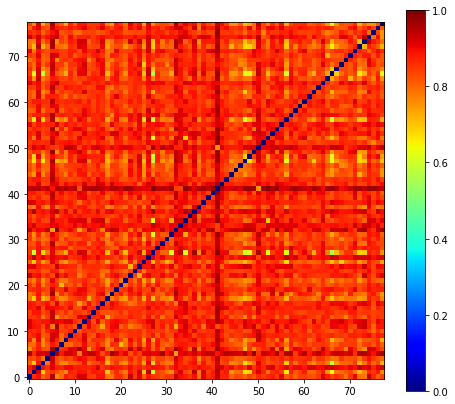

In [89]:
# plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

plt.imshow(
    data_total_all,
    origin ='lower',
    cmap='jet',
    vmax = 1 
)
plt.colorbar()

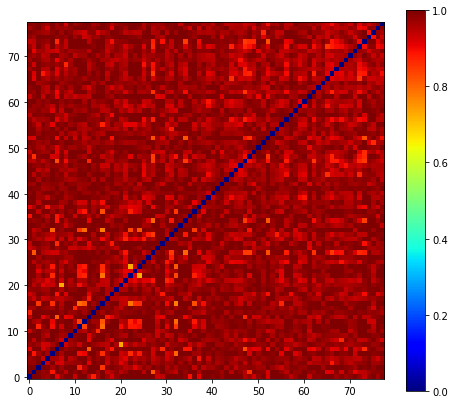

In [87]:
# plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

plt.imshow(
    data_cluster[0],
    origin ='lower',
    cmap='jet', 
    vmax = 1
)
plt.colorbar()

In [80]:
for i in range(len(labels)):
    total = 0
    for j in range(len(labels)):
        t_ana, p_ana = stats.kendalltau(data_cluster_inanimate[i],  data_cluster_animate[j])
        total+= t_ana
        #print(i,j, t_ana)
    print(i, total)

(0, 1.7430918835661189)
(1, 0.6448358929477958)
(2, 0.9157826763112741)
(3, 0.9678589760861472)
(4, 0.3157441671673608)
(5, 0.6747576062066808)
(6, 0.1840454675753506)
(7, 0.7498525589410555)
(8, 1.798054507816061)
(9, 1.4313206702186372)
(10, 1.279226380301231)
(11, 1.2278412042753268)
(12, 1.1941251056122058)
(13, 0.9611993281258548)
(14, 0.8718208365323885)
(15, 0.6867978106819936)
(16, 1.0022842668768956)
(17, 1.09785964789979)
(18, 0.9579193777265893)
(19, 0.7274328798584591)
(20, 0.8233652658774521)
(21, 1.5921907803364685)
(22, 1.0105661631740632)


In [82]:
for i in range(len(labels)):
    total = 0
    for j in range(len(labels)):
        t_ana, p_ana = stats.kendalltau(data_cluster_animate[i],  data_cluster_inanimate[j])
        total+= t_ana
        #print(i,j, t_ana)
    print(i, total)

(0, 1.1183757090514854)
(1, 1.0140852579496134)
(2, 0.7917867484128419)
(3, 1.1801543119736146)
(4, 1.2299193077907937)
(5, 0.7640163812898983)
(6, 0.6905602943002297)
(7, 1.2009707388466775)
(8, 1.0505166555214986)
(9, 1.3629749009956211)
(10, 0.8248394919655505)
(11, 0.7489709796915077)
(12, 0.7479897152694664)
(13, 0.9307822342928199)
(14, 0.9842732416010856)
(15, 1.06026224732705)
(16, 1.236009408682828)
(17, 1.3276565492953274)
(18, 0.6885928134058723)
(19, 1.2014469876415215)
(20, 0.8070125983014395)
(21, 1.0288149802172126)
(22, 0.8679619002912453)
